# Nonlinearsolve.jl Package

### CSCI 3656
### Michael Wallace, Kyle Okura, Alex Warren, Mark Worster

# Introduction

Nonlinearsolve.jl is a Julia package that serves as a unified interface for solving nonlinear systems and root-finding problems. It was created to give users the flexibility to switch between native algorithms and external libraries to find the fastest solver for their specific model. The package is capable of handling everything from small static problems to large-scale sparse systems, leveraging automatic differentiation and seamless integration with the Scientific Machine Learning (SciML) ecosystem for maximum efficiency.

# Setup

In [48]:
using Pkg
Pkg.add("NonlinearSolve")

Pkg.add("BenchmarkTools")
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `C:\Users\kyleo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\kyleo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\kyleo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\kyleo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\kyleo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\kyleo\.julia\environments\v1.11\Manifest.toml`


### Exploring the execution time between different rootfinding algorithms

In [1]:
using NonlinearSolve
using BenchmarkTools # For timing
using Plots

#System of Equations
#F1 is a Circle, F2 is a line
function f_system!(F, u, p)
    x, y = u
    F[1] = x^2 + y^2 - 4
    F[2] = x - y - 1
end

# Initial guess
u0 = [1.0, 1.0]

prob = NonlinearProblem(f_system!, u0)

NonlinearProblem with uType Vector{Float64}. In-place: true
u0: 2-element Vector{Float64}:
 1.0
 1.0

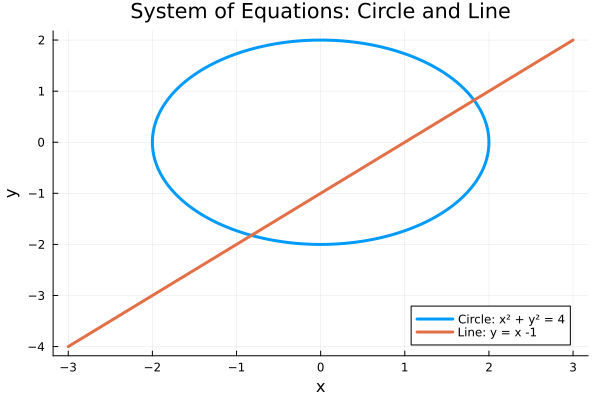

In [2]:
# Graphing our functions
using Plots

# graph of our circle (x)^2 + (y)^2 = 4
θ = range(0, 2π, length=400)
x_circle = 2cos.(θ)
y_circle = 2sin.(θ)

# graph of our line y = x - 1   
x_line = range(-3, 3, length=400)
y_line = 1 .* x_line .- 1


plot(x_circle, y_circle,label="Circle: x² + y² = 4",linewidth=3)

plot!(x_line, y_line,label="Line: y = x -1",linewidth=3)


xlabel!("x")
ylabel!("y")
title!("System of Equations: Circle and Line")


Before we check the preformance of some of our solvers, lets look at if they can solve our problem correctly.

In [3]:
@show solve(prob, NewtonRaphson()) 
@show solve(prob, TrustRegion())
@show solve(prob, Broyden())
@show solve(prob,Klement());

solve(prob, NewtonRaphson()) = [1.8228756555322954, 0.8228756555322954]
solve(prob, TrustRegion()) = [1.8228756555322954, 0.8228756555322952]
solve(prob, Broyden()) = [1.8228756555322954, 0.8228756555322952]
solve(prob, Klement()) = [1.8228756555323442, 0.8228756555319636]


Now that we know at all of these solvers give us correct answers, we can look at the performance of each one.

In [4]:
using Printf #for better output formatting

"""
run_solver(prob, alg)
Solves the problem using a specific algorithm and returns the solution and the number of iterations
"""
function run_solver(prob, alg)
    sol = solve(prob, alg)
    return sol.u, sol.stats.nsteps
end


"""
test_algorithms(prob, alg_list)
Tests the problem on a list of algorithms
"""
function test_algorithms(prob, alg_list)
    println("----------------------------------------------------------------")
    @printf "%-30s | %-12s | %-15s\n" "Algorithm" "Iterations" "Time (Median)"
    println("----------------------------------------------------------------")

    for (name, alg) in alg_list
        # Get Iteration Count
        _, iterations = run_solver(prob, alg)

        # Benchmark Time
        time_sec = @belapsed solve($prob, $alg)

        # Convert to microseconds for better formatting
        time_microseconds = time_sec * 1e6

        @printf "%-30s | %-12d | %.2f μs\n" name iterations time_microseconds
    end
    println("----------------------------------------------------------------")
end

test_algorithms

In [5]:
methods = [
    ("NewtonRaphson", NewtonRaphson()), # Newtons method - requires Jacobian Matrix (matrix that contains derivatives)
    ("TrustRegion", TrustRegion()),   # Modification of Newton that keeps a region where the guesses will be more accurate
    ("Broyden", Broyden()),       # Quasi-Newton - doesn't make the full Jacobian Matrix, rather it makes guesses of the slopes nearby, then updates them with each iteration
    ("Klement", Klement())        # Another Quasi-Newton method similar to Broyden
]

test_algorithms(prob, methods)

----------------------------------------------------------------
Algorithm                      | Iterations   | Time (Median)  
----------------------------------------------------------------
NewtonRaphson                  | 5            | 17.13 μs
TrustRegion                    | 7            | 21.96 μs
Broyden                        | 11           | 6.71 μs
Klement                        | 205          | 63.43 μs
----------------------------------------------------------------


### Differences between each solver
 * NewtonRaphson - uses true Jacobian to solve for next step, usually quadtratic convergence, classic
 * TrustRegion - approximates the objective function within a "trust region" and adjusts the region's size, still requires Jacobian, robust when initial guess is bad
 * Broyden - Quasi-newton method, approximates Jacobian, only calculates it on the first attempt, less computationally costly, good for larger systems
 * Klement - Variation of Broyden, different approximation method, generally more efficient than Broyden, can be unstable if Jacobian is ill-conditioned.

### Breaking Newton's Method

In [6]:
"""
f_newton_fail!(F, u, p)
function that includes an equation where the derivative is 0
"""

function f_newton_fail!(F, u, p)
    x, y = u
    F[1] = x^2 - 2  # Derivative is 2x. At x=0, derivative is 0.
    F[2] = y^2 - 2
end

u0_initial = [0.0, 0.0] # Starting where the derivative is 0
prob_newton_fail = NonlinearProblem(f_newton_fail!, u0_initial)

println("--- NewtonRaphson Failure Case ---")
sol = solve(prob_newton_fail, NewtonRaphson())
println("Return Code: ", sol.retcode)


--- NewtonRaphson Failure Case ---


┌ Warning: Potential Rank Deficient Matrix Detected. Attempting to solve using Pivoted QR Factorization.
└ @ NonlinearSolveBaseLinearSolveExt ~/.julia/packages/NonlinearSolveBase/5ckRl/ext/NonlinearSolveBaseLinearSolveExt.jl:33
┌ Warning: Potential Rank Deficient Matrix Detected. Attempting to solve using Pivoted QR Factorization.
└ @ NonlinearSolveBaseLinearSolveExt ~/.julia/packages/NonlinearSolveBase/5ckRl/ext/NonlinearSolveBaseLinearSolveExt.jl:33
┌ Warning: Potential Rank Deficient Matrix Detected. Attempting to solve using Pivoted QR Factorization.
└ @ NonlinearSolveBaseLinearSolveExt ~/.julia/packages/NonlinearSolveBase/5ckRl/ext/NonlinearSolveBaseLinearSolveExt.jl:33
┌ Warning: Potential Rank Deficient Matrix Detected. Attempting to solve using Pivoted QR Factorization.
└ @ NonlinearSolveBaseLinearSolveExt ~/.julia/packages/NonlinearSolveBase/5ckRl/ext/NonlinearSolveBaseLinearSolveExt.jl:33
┌ Warning: Potential Rank Deficient Matrix Detected. Attempting to solve using Pivoted Q

Return Code: Stalled


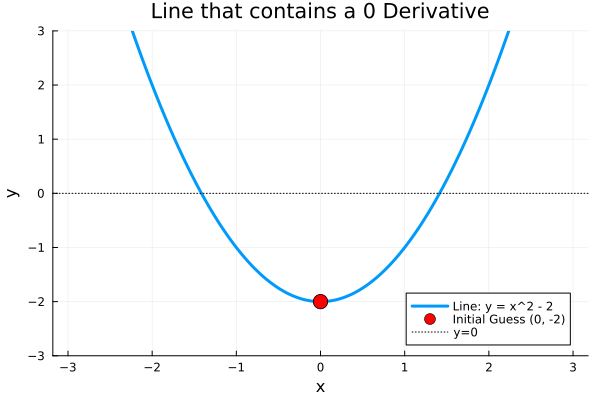

In [7]:
# graph of our line y = x^2 - 2 
x_line = range(-3, 3, length=400)
y_line = 1 .* x_line .^2 .- 2

#plotting our line
plot(x_line, y_line, label="Line: y = x^2 - 2",linewidth=3)

#plotting where our initial guess is
scatter!([0], [-2], label="Initial Guess (0, -2)", markersize=8, color=:red)

#including y=0 (solution) line
hline!([0], linestyle=:dot, color=:black, label="y=0")

ylims!(-3, 3)
xlabel!("x")
ylabel!("y")
title!("Line that contains a 0 Derivative")


## Explanation
Since Newton's method relies on using the derivative at each step to make a new guess, it won't be able to find the root if it lands on a point where the derivative is 0.

## Changing the Starting Point
But if we change the inital guess of our function we can see that Newton's method still works as long as it doesn't get to x=0.

In [8]:
u0_initial = [2.0, 2.0] # creating a new starting point where the derivative isn't 0

prob_newton_fix = NonlinearProblem(f_newton_fail!, u0_initial)
cache = init(prob_newton_fix, NewtonRaphson())

#storring the guesses from Newton's Method
guesses = [u0_initial[1]]
for x in 1:4
    step!(cache)
    push!(guesses, cache.u[1])
end

println("--- NewtonRaphson Fix ---")
sol = solve(prob_newton_fix, NewtonRaphson())
println("Return Code: ", sol.retcode)
println("Solution: ", sol)

--- NewtonRaphson Fix ---
Return Code: Success
Solution: [1.4142135623730951, 1.4142135623730951]


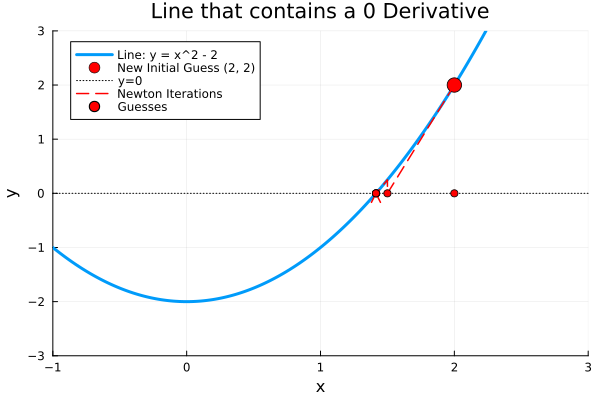

In [9]:
# graph of our line y = x^2 - 2 
x_line = range(-3, 3, length=400)
y_line = 1 .* x_line .^2 .- 2

#plotting our line
plot(x_line, y_line, label="Line: y = x^2 - 2",linewidth=3)

#plotting where our new initial guess
scatter!([2], [2], label="New Initial Guess (2, 2)", markersize=8, color=:red)

#including y=0 (solution) line
hline!([0], linestyle=:dot, color=:black, label="y=0")

path_x = Float64[]
path_y = Float64[]

for x in guesses
    y_val = x^2 - 2
    push!(path_x, x)
    push!(path_y, 0)
    push!(path_x, x)
    push!(path_y, y_val)
end

popfirst!(path_x)
popfirst!(path_y)

plot!(path_x, path_y, 
      label="Newton Iterations", 
      color=:red, 
      arrow=true,
      linewidth=1.5,
      linestyle=:dash)

scatter!(guesses, zeros(length(guesses)), color=:red, label="Guesses")

xlims!(-1, 3)
ylims!(-3, 3)
xlabel!("x")
ylabel!("y")
title!("Line that contains a 0 Derivative")

### Breaking Trust Region
Trust region requires a Jacobian, but it tends to stall when it is given a low rank or singular one. We will take the system:
$$
\begin{cases}
    f_1(x,y) = x^2 + y^2 -4 \\
    f_2(x,y) = x-y-1
\end{cases}
$$

The Jacobian of this function is:
$$
J(x,y) = \begin{pmatrix}
2x & 2y \\
1 & -1
\end{pmatrix}
$$

The rows in this are nearly linearly indpendent, so the Jacobian is close to singular which causes the stall

In [19]:
function f_system!(F, u, p)
    x, y = u
    F[1] = x^2 + y^2 - 4             # Circle of radius 2
    F[2] = (x - y - 1)          #line
end

u0 = [1.0, -1.0]   #or try [5.0, -2.0] or [1.0, -1.0]
prob = NonlinearProblem(f_system!, u0)
sol = solve(prob, TrustRegion())

sol

    sol = solve(prob, TrustRegion())
    println("status: ", sol.retcode,)
    println("solution approx: ", sol.u)

status: Stalled
solution approx: [1.1437398936440173, -1.1437398936440173]


┌ Warning: Potential Rank Deficient Matrix Detected. Attempting to solve using Pivoted QR Factorization.
└ @ NonlinearSolveBaseLinearSolveExt ~/.julia/packages/NonlinearSolveBase/5ckRl/ext/NonlinearSolveBaseLinearSolveExt.jl:33
┌ Warning: Potential Rank Deficient Matrix Detected. Attempting to solve using Pivoted QR Factorization.
└ @ NonlinearSolveBaseLinearSolveExt ~/.julia/packages/NonlinearSolveBase/5ckRl/ext/NonlinearSolveBaseLinearSolveExt.jl:33
┌ Warning: Potential Rank Deficient Matrix Detected. Attempting to solve using Pivoted QR Factorization.
└ @ NonlinearSolveBaseLinearSolveExt ~/.julia/packages/NonlinearSolveBase/5ckRl/ext/NonlinearSolveBaseLinearSolveExt.jl:33
┌ Warning: Potential Rank Deficient Matrix Detected. Attempting to solve using Pivoted QR Factorization.
└ @ NonlinearSolveBaseLinearSolveExt ~/.julia/packages/NonlinearSolveBase/5ckRl/ext/NonlinearSolveBaseLinearSolveExt.jl:33


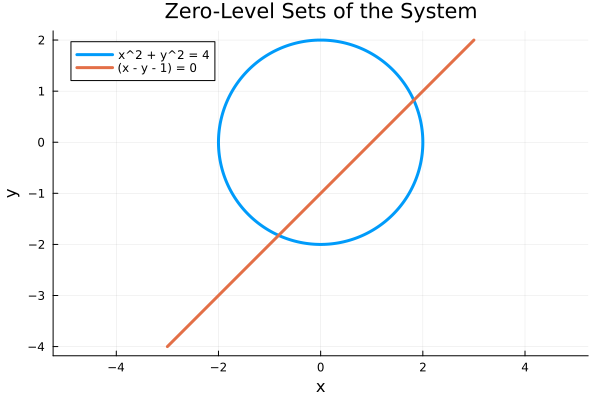

In [20]:
# Circle (x^2 + y^2 = 4)
θ = range(0, 2π, length=400)
x_circle = 2 .* cos.(θ)
y_circle = 2 .* sin.(θ)

# Line (x - y - 1 = 0 ⇒ y = x - 1)
x_line = range(-3, 3, length=400)
y_line = x_line .- 1

# Plot
plot(x_circle, y_circle,
     label="x^2 + y^2 = 4",
     linewidth=3)

plot!(x_line, y_line,
      label="(x - y - 1) = 0",
      linewidth=3)

plot!(xlabel="x", ylabel="y", aspect_ratio=1, grid=true,
      title="Zero-Level Sets of the System")

This package has a built in work around for problems like this. When it says Pivoted QR Factorization, it switches to a least squares problem and solves 
$$
\min || J_p + F||
$$

### Breaking Broyden
We will break this solver by using a function that doesn't have a derivative. Take the system 
$$
 \begin{cases}
    f_1(x,y) = x^2 \\
    f_2(x,y) = \sqrt{|x|}
\end{cases}
$$

This makes Broydens approximation garbage immediately

In [21]:
function f_system!(F, u, p)
    x, y = u
    F[1] = x^2
    F[2] = sqrt(abs(x))
end

u0 = [1.0, 1.0]

prob = NonlinearProblem(f_system!, u0)

sol_broyden = solve(prob, Broyden())

sol_broyden

retcode: MaxIters
u: 2-element Vector{Float64}:
  0.0004354569262426944
 -2.277720371848547e60

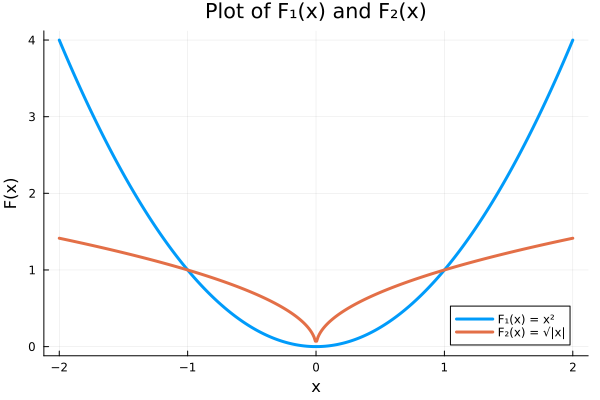

In [23]:
F1(x) = x^2
F2(x) = sqrt(abs(x))
xs = range(-2, 2, length=400)
ys1 = F1.(xs)
ys2 = F2.(xs)

# Plot
plot(xs, ys1,label="F₁(x) = x²",lw=3)

plot!(xs, ys2,label="F₂(x) = √|x|",lw=3)

xlabel!("x")
ylabel!("F(x)")
title!("Plot of F₁(x) and F₂(x)")

### Breaking Klement

In [12]:
"""
f_klement_fail!(F, u, p)
A system of equations with no solution
y = x^3 + 1
y = x^3 + 3
There is no solution, and the Jacobian is singular everywhere.
"""
function f_klement_fail!(F, u, p)
    x, y = u
    F[1] = -x^3 + y - 1
    F[2] = -x^3 + y - 3
end

u0_klement = [1.0, 1.0]
prob_klement_fail = NonlinearProblem(f_klement_fail!, u0_klement)
cache = init(prob_klement_fail, Klement(), maxiters=100)

# We limit maxiters because it might just spin forever without converging
sol_klement = solve(prob_klement_fail, Klement(), maxiters=100)

println("Return Code: ", sol_klement.retcode)
println("Final Residual: ", sol_klement.resid)

Return Code: MaxIters
Final Residual: [0.9903419571325358, -1.0096580428674642]


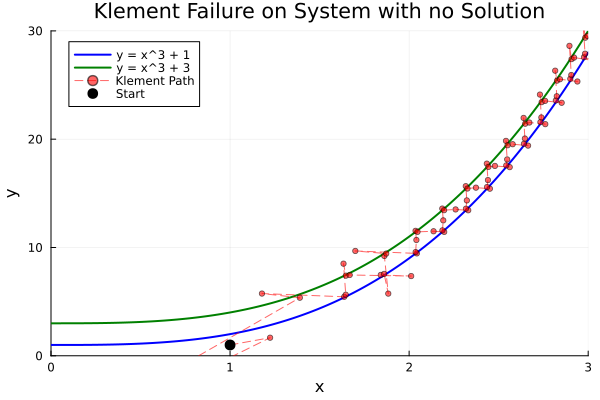

In [13]:
guesses_x = [u0_klement[1]]
guesses_y = [u0_klement[2]]

for i in 1:100
    step!(cache)
    push!(guesses_x, cache.u[1])
    push!(guesses_y, cache.u[2])
end

# Lines in our system
x_range = range(-2, 5, length=400)
y_curve1 = x_range.^3 .+ 1
y_curve2 = x_range.^3 .+ 3

plot(x_range, y_curve1, label="y = x^3 + 1", linewidth=2, color=:blue)
plot!(x_range, y_curve2, label="y = x^3 + 3", linewidth=2, color=:green)

# Plotting each iteration
plot!(guesses_x, guesses_y, 
      label="Klement Path", 
      color=:red, 
      marker=:circle, 
      markersize=3,
      linestyle=:dash,
      alpha=0.6)

#Marking Starting point
scatter!([guesses_x[1]], [guesses_y[1]], color=:black, markersize=6, label="Start")

title!("Klement Failure on System with no Solution")
xlabel!("x")
ylabel!("y")
xlims!(0, 3)
ylims!(0, 30)

Since Klement uses approximations of the slopes instead of directly calculating each one, the guesses will come with errors that create the zigzag pattern shown above. You can see that there are 2 guesses between the lines, then another outside of them. This is because since it didn't get any closer to a solution (that doesn't exist), it overcorrects to try and find where it might be closer to the solution. It then returns to the area between the lines and repeats. 